In [1]:
import sys

sys.path.append('../..')

import warnings
warnings.filterwarnings('ignore')

In [12]:
from partition import EmbeddingsPartition
from projections import SimplexProjection

import numpy as np
import matplotlib.pyplot as plt
from imblearn.datasets import fetch_datasets

dataset_name = 'mammography'


dataset = fetch_datasets()[dataset_name]
X = dataset.data
y = dataset.target

minor_class = np.min(y)
train_embeddings = X[y == minor_class]
test_embeddings = X[y != minor_class]

print(len(test_embeddings), len(train_embeddings))

# np.random.seed(42)
# test_sample_indices = np.random.choice(test_embeddings_full.shape[0], min(1000, len(test_embeddings_full)), replace=False)
# test_embeddings = test_embeddings_full[test_sample_indices]

max_k = 10
max_t = 11
t_values = range(1, max_t + 1, 2)
k_values = range(1, max_k + 1)

partitioner = EmbeddingsPartition(train_embeddings, dimension=train_embeddings.shape[1])

all_projections = {t: [] for t in t_values}

number_of_simplexes = {t: [] for t in t_values}

def filter_simplexes_by_size(simplexes, size):
    return [simplex for simplex in simplexes if len(simplex) == size]

for t in t_values:
    print(f"Building simplexes with max_k={max_k} and t={t}")
    all_simplexes = partitioner.run_method("clique", k=max_k, t=t)
    print(f"Total simplexes {len(all_simplexes)}")

    for k in k_values:
        print(f"Filtering simplexes to size k={k} for t={t}")
        filtered_simplexes = filter_simplexes_by_size(all_simplexes, k)
        print(f"Simplexes with size={k}, {len(filtered_simplexes)}")
        number_of_simplexes[t].append(len(filtered_simplexes))

        simplex_projection = SimplexProjection(filtered_simplexes)

        projections = simplex_projection.find_closest_projections(test_embeddings)
        if projections[0].sum() == 0:
            all_projections[t].append([])
            continue
        
        distances = np.linalg.norm(test_embeddings - projections, axis=1)
        mean_distance = np.mean(distances)
        all_projections[t].append(projections)

        print(f"Mean distance for k={k}, t={t}: {mean_distance}")

260 10923
Building simplexes with max_k=10 and t=1
Total simplexes 14251
Filtering simplexes to size k=1 for t=1
Simplexes with size=1, 10923
Filtering simplexes to size k=2 for t=1
Simplexes with size=2, 3328
Filtering simplexes to size k=3 for t=1
Simplexes with size=3, 0
Filtering simplexes to size k=4 for t=1
Simplexes with size=4, 0
Filtering simplexes to size k=5 for t=1
Simplexes with size=5, 0
Filtering simplexes to size k=6 for t=1
Simplexes with size=6, 0
Filtering simplexes to size k=7 for t=1
Simplexes with size=7, 0
Filtering simplexes to size k=8 for t=1
Simplexes with size=8, 0
Filtering simplexes to size k=9 for t=1
Simplexes with size=9, 0
Filtering simplexes to size k=10 for t=1
Simplexes with size=10, 0
Building simplexes with max_k=10 and t=3
Total simplexes 46611
Filtering simplexes to size k=1 for t=3
Simplexes with size=1, 10923
Filtering simplexes to size k=2 for t=3
Simplexes with size=2, 20599
Filtering simplexes to size k=3 for t=3
Simplexes with size=3, 1176

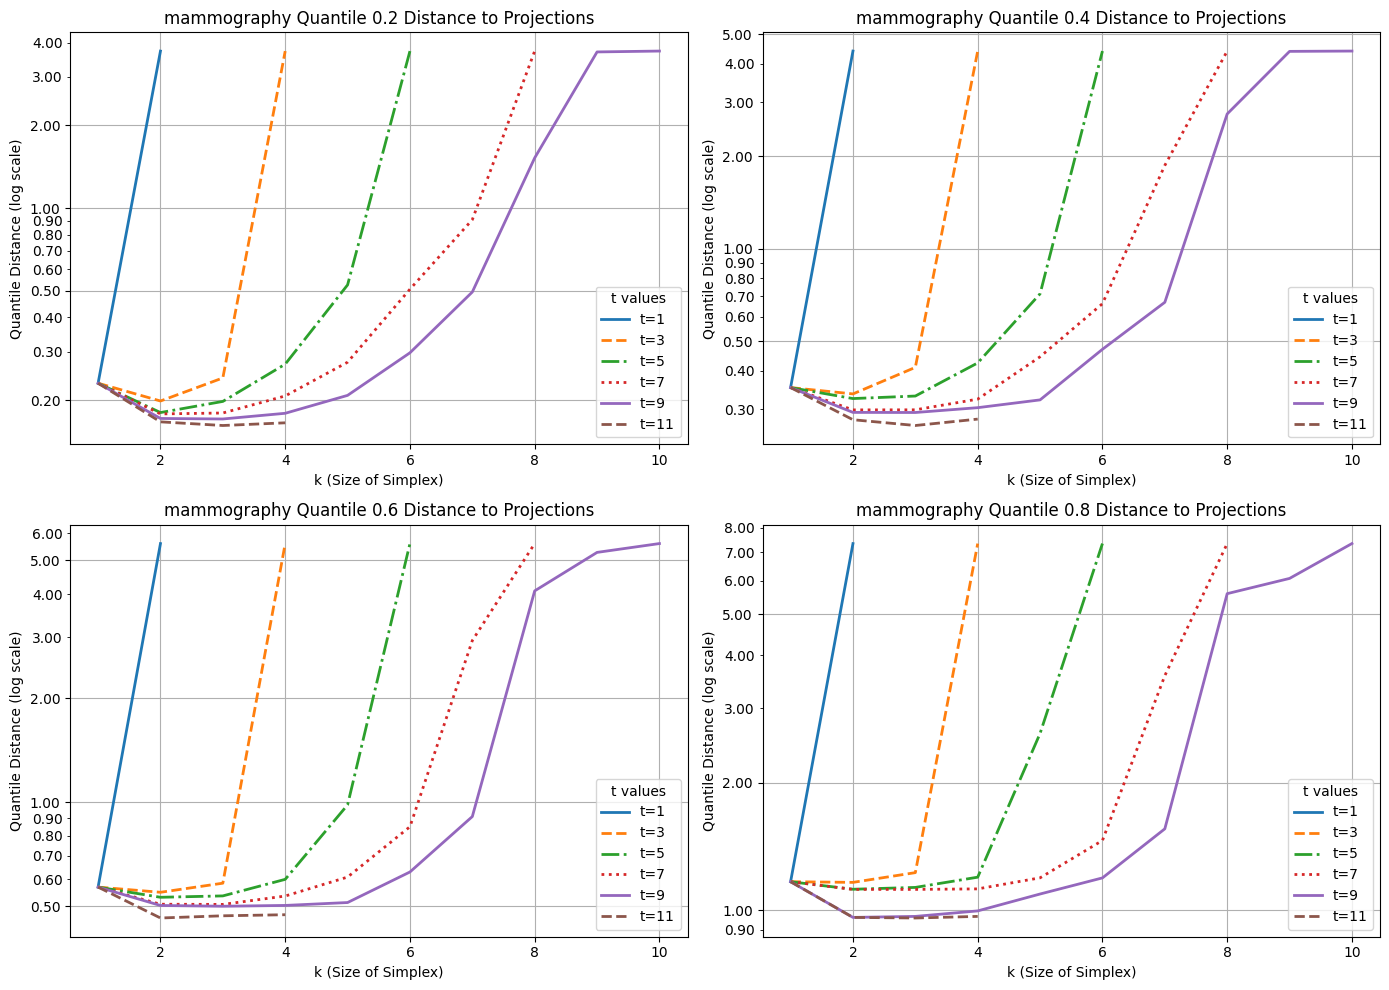

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import LogLocator, LogFormatter

quantiles = [0.2, 0.4, 0.6, 0.8]
quantile_results = {t: {q: [] for q in quantiles} for t in t_values}

def calculate_quantiles():
    for t in t_values:
        for idx, k in enumerate(k_values):
            if idx >= len(all_projections[t]):
                for q in quantiles:
                    quantile_results[t][q].append(1e9)
                continue
            projection_set = all_projections[t][idx]
            if len(projection_set) > 0:
                distances = np.linalg.norm(test_embeddings - projection_set, axis=1)
                for q in quantiles:
                    quantile_value = np.quantile(distances, q)
                    quantile_results[t][q].append(quantile_value)
            else:
                for q in quantiles:
                    quantile_results[t][q].append(1e9)
                
calculate_quantiles()

def custom_point_formatter(x, pos):
    if x >= 1:
        return f'{x:.2f}'
    else:
        return f'{x:.2f}'

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()
line_styles = ['-', '--', '-.', ':', '-', '--', '-.']
line_widths = [2, 2, 2, 2]

for ax, q in zip(axs, quantiles):
    for i, t in enumerate(t_values):
        valid_indices = [i for i, val in enumerate(quantile_results[t][q]) if val < 1e9]
        valid_k_values = [k_values[i] for i in valid_indices]
        valid_quantiles = [quantile_results[t][q][i] for i in valid_indices]
        ax.plot(valid_k_values, valid_quantiles, label=f't={t}', linestyle=line_styles[i % len(line_styles)], linewidth=line_widths[i % len(line_widths)])
    ax.set_title(f"{dataset_name} Quantile {q} Distance to Projections")
    ax.set_yscale('log')
    ax.set_xlabel("k (Size of Simplex)")
    ax.set_ylabel("Quantile Distance (log scale)")
    ax.legend(title="t values")
    ax.grid(True)
    
    ax.yaxis.set_major_locator(LogLocator(base=10.0, subs=(1.0, 2.0, 5.0), numticks=7))
    ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=7))
    
    ax.yaxis.set_major_formatter(FuncFormatter(custom_point_formatter))
    ax.yaxis.set_minor_formatter(FuncFormatter(custom_point_formatter))

plt.tight_layout()
plt.show()

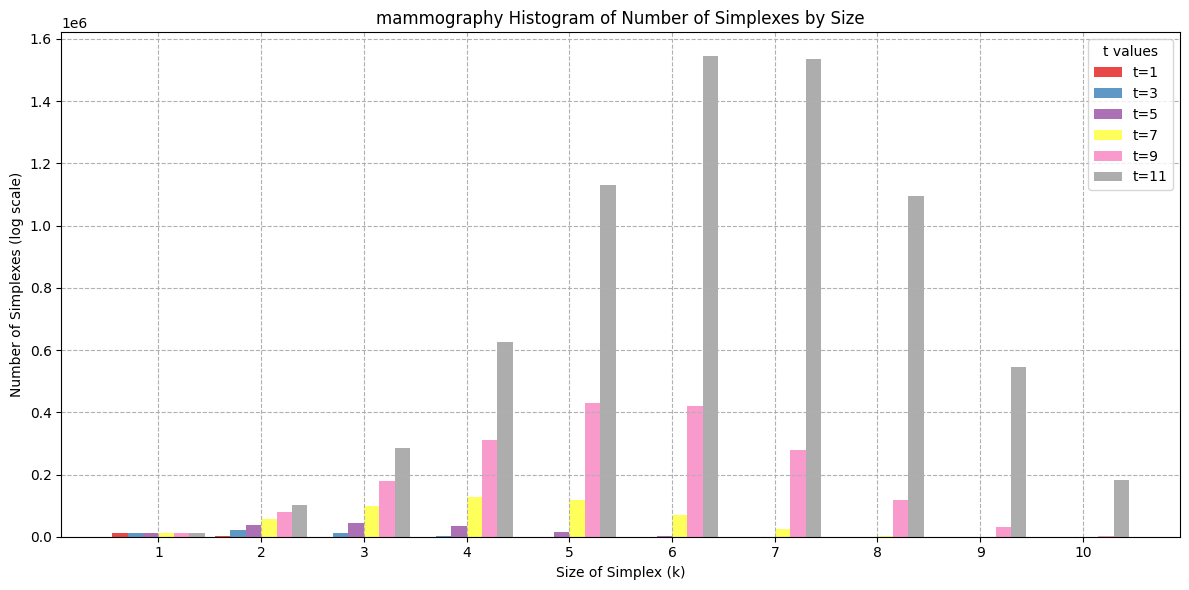

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

colors = plt.cm.Set1(np.linspace(0, 1, len(t_values)))

bar_width = 0.15 
offset = bar_width * len(t_values) / 2
for i, t in enumerate(sorted(t_values)):
    simplex_sizes = k_values
    counts = number_of_simplexes[t]
    bar_positions = [size + (i * bar_width) - offset + (bar_width / 2) for size in simplex_sizes]
    ax.bar(bar_positions, counts, alpha=0.8, label=f't={t}', color=colors[i], width=bar_width)

ax.set_xticks([size for size in k_values])
ax.set_xticklabels([str(size) for size in k_values])

# ax.set_yscale('log')

ax.set_xlabel('Size of Simplex (k)')
ax.set_ylabel('Number of Simplexes (log scale)')
ax.set_title(f'{dataset_name} Histogram of Number of Simplexes by Size')
ax.legend(title="t values")
ax.grid(True, which="both", ls="--")

plt.tight_layout()
plt.show()
